In [1]:
%%capture
%pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate torchvision pandas==1.5.2

In [2]:
import torch
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([1, 256, 256])


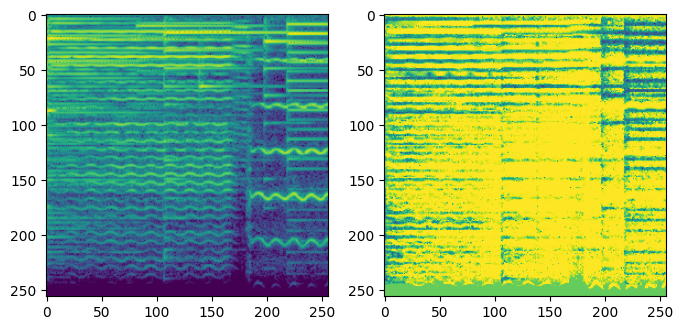

In [3]:
from dataset import SpectrogramDataset

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True,
                            out_channels=1,
                            return_mask=True
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True,
                          out_channels=1,
                          return_mask=True
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=1,
                           return_mask=True
                     )

img1,img2=train_ds[0]
print(img1.shape)

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

In [4]:
class plUnet(pl.LightningModule):
    def __init__(self,
                 train_dataset,
                 valid_dataset,
                 batch_size,
                 lr=1e-4,
                 warm_up_steps=10000,
                 loss_fn=torch.nn.functional.l1_loss):
        super().__init__()
        self.save_hyperparameters()
        self.train_dataset=train_dataset
        self.valid_dataset=valid_dataset
        self.batch_size=batch_size
        self.lr=lr
        self.warm_up_steps= warm_up_steps
        self.loss_fn = loss_fn

        channels, h, w = train_dataset[0][0].shape

        self.model=UnetConvNextBlock(dim=64,
                                     dim_mults = (1,2,4,8),
                                     channels=channels,
                                     out_dim=channels,
                                     with_time_emb=False)
        
    def forward(self, x):
        return self.output_T(self.model(self.input_T(x)))
    
    def input_T(self, input):
        # By default, let the model accept samples in [0,1] range, and transform them automatically
        return (input.clip(0,1).mul_(2)).sub_(1)
    
    def output_T(self, input):
        # Inverse transform of model output from [-1,1] to [0,1] range
        return (input.add_(1)).div_(2)
    
    def training_step(self, batch, batch_idx):
        mix, source = batch
        model_output=self.model(self.input_T(mix))

        loss = self.loss_fn(model_output, self.input_T(source))
        
        self.log('train_loss',loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        mix, source = batch
        model_output=self.model(self.input_T(mix))

        loss = self.loss_fn(model_output, self.input_T(source))
        
        self.log('train_loss',loss, prog_bar=True)
        return loss
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=4)
    
    def val_dataloader(self):
        if self.valid_dataset is not None:
            return DataLoader(self.valid_dataset,
                              batch_size=self.batch_size,
                              shuffle=False,
                              num_workers=4)
        else:
            return None
        
    def configure_optimizers(self):
        return  torch.optim.AdamW(list(filter(lambda p: p.requires_grad, self.model.parameters())), lr=self.lr)
    
    def optimizer_step(self, epoch, 
                       batch_idx, 
                       optimizer,
                       optimizer_closure):
        
        # Linear Warm-up
        if self.trainer.global_step < self.warm_up_steps:
            lr_scale = min(1.0, float(self.trainer.global_step + 1) / self.warm_up_steps)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * self.lr

        optimizer.step(closure=optimizer_closure)

        self.log('lr', pg['lr'], prog_bar=True)

        return super().optimizer_step(epoch, batch_idx, optimizer, optimizer_closure)
    
model = plUnet(train_dataset=train_ds,
               valid_dataset=valid_ds,
               batch_size=8)

Is Time embed used ?  False


In [5]:
trainer = pl.Trainer(
    default_root_dir="trained_models/unet/",
    max_epochs=1000,
    callbacks=[EMA(0.9999)],
    accelerator='auto'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | UnetConvNextBlock | 56.3 M
--------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    Total params
225.104   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 trainer.fit(model)                                                                           │
│   2                                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:531 in fit           │
│                                                                                                  │
│    528 │   │   """                                                                               │
│    529 │   │   model = _maybe_unwrap_optimized(model)                                            │
│    530 │   │   self.strategy._lightning_module = model                                           │
│ ❱  531 │   │   call._call_and_handle_interrupt(                                                  │
│    532 │   │   │   self, self._fit_impl, model, train_dataloaders, val_dataloaders, datamodule,  │
│    533 │   │   )                                                                                 │
│    534                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/call.py:42 in                   │
│ _call_and_handle_interrupt                                                                       │
│                                                                                                  │
│    39 │   try:                                                                                   │
│    40 │   │   if trainer.strategy.launcher is not None:                                          │
│    41 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│ ❱  42 │   │   return trainer_fn(*args, **kwargs)                                                 │
│    43 │                                                                                          │
│    44 │   except _TunerExitException:                                                            │
│    45 │   │   _call_teardown_hook(trainer)                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:570 in _fit_impl     │
│                                                                                                  │
│    567 │   │   │   model_provided=True,                                                          │
│    568 │   │   │   model_connected=self.lightning_module is not None,                            │
│    569 │   │   )                                                                                 │
│ ❱  570 │   │   self._run(model, ckpt_path=ckpt_path)                                             │
│    571 │   │                                                                                     │
│    572 │   │   assert self.state.stopped                                                         │
│    573 │   │   self.training = False                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:975 in _run          │
│                                                                                                  │
│    972 │   │   # ----------------------------              

In [7]:
trainer.fit(model, ckpt_path='trained_models/unet/lightning_logs/version_2/checkpoints/epoch=157-step=9954.ckpt')

Restoring states from the checkpoint path at trained_models/unet/lightning_logs/version_2/checkpoints/epoch=157-step=9954.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | UnetConvNextBlock | 56.3 M
--------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    Total params
225.104   Total estimated model params size (MB)
Restored all states from the checkpoint at trained_models/unet/lightning_logs/version_2/checkpoints/epoch=157-step=9954.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [16]:
input,output=test_ds[0]
batch_input=torch.stack(1*[input],0).to(device)

model.to(device)
out=model(batch_input)

(-0.5, 255.5, 255.5, -0.5)

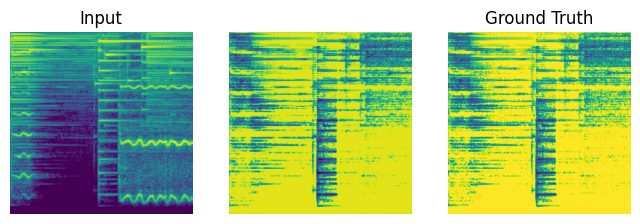

In [17]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')